# Test case LVV-T956-a: Impacted Ghost Area

> **Percentage of image area that can have ghosts with surface brightness gradient amplitude of more than 1/3 of the sky noise over 1 arcsec shall be less than 1% of the area**

This test verifies the following requirements:

- LSR-REQ-0093-V-10: Ghost Image Control - Image Area Affected (https://rubinobs.atlassian.net/browse/LVV-20652)

In [1]:
%load_ext autoreload
%autoreload 2

# rayven is a package built to connect LSST tools with Batoid to simulate ghosts
import rayven as rv
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.stats import binned_statistic_2d

from lsst.daf.butler import Butler
from lsst.summit.utils import ConsDbClient
import lsst.afw.cameraGeom as afwCameraGeom


## Simulate Ghosts Using Batoid & Rayven

In [2]:
visit = 2025071700171
gt = rv.GhostTool(visit=2025071700171)
tab = deepcopy(gt.camera_geometry.det_geometry_table)

In [3]:
gfs = gt.batoid_simulator.simulate_fov()

/home/p/pai/sciunit_lsb/notebooks/ipykernel_31234/3314876407.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(gfs.bin(500)), cmap='inferno', extent=[rv.LSSTCamConstants.fp_min_x.value,


Text(0.5, 1.0, 'Batoid Ghost Simulation \n visit: 2025071700171 \n band: u')

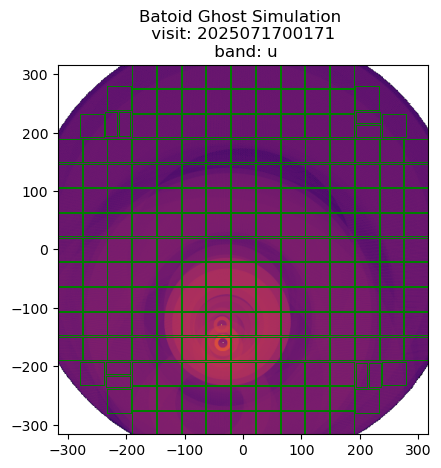

In [4]:
plt.imshow(np.log10(gfs.bin(500)), cmap='inferno', extent=[rv.LSSTCamConstants.fp_min_x.value, 
                                                      rv.LSSTCamConstants.fp_max_x.value, 
                                                      rv.LSSTCamConstants.fp_min_y.value, 
                                                      rv.LSSTCamConstants.fp_max_y.value])

for j in range(205):
        min_x = tab['min_x']
        min_y = tab['min_y']
    
        max_x = tab['max_x']
        max_y = tab['max_y']
        plt.vlines(min_x, min_y, max_y, color='g', lw=0.5)
        plt.hlines(min_y, min_x, max_x, color='g', lw=0.5)
        plt.vlines(max_x, min_y, max_y, color='g', lw=0.5)
        plt.hlines(max_y, min_x, max_x, color='g', lw=0.5)
    
plt.title(f'Batoid Ghost Simulation \n visit: {visit} \n band: {gt.obs_params.band}')

## Setup

calculate edges of each detector to bin the ghosts per detector

In [5]:
x_binsize, y_binsize = [], []

x_detectors = [75, 76, 77, 84, 85, 86, 93, 94, 95, 102, 103, 104, 111, 112, 113]
y_detectors = [10, 13, 16, 46, 49, 52, 91, 94, 97, 136, 139, 142, 172, 175, 178]

for i, j in zip(x_detectors, x_detectors[1:]):
    x_binsize.append(tab[tab['detector']==j]['max_x'] - tab[tab['detector']==i]['max_x'])

for i, j in zip(y_detectors, y_detectors[1:]):    
    y_binsize.append(tab[tab['detector']==j]['min_y'] - tab[tab['detector']==i]['min_y'])
    
x_bins = [tab[tab['detector']==x_detectors[0]]['min_x'].value + np.sum(x_binsize[:i]) for i in range(len(x_binsize)+1)]
x_bins.append(tab[tab['detector']==x_detectors[-1]]['max_x'].value)

y_bins = [tab[tab['detector']==y_detectors[0]]['min_y'].value + np.sum(y_binsize[:i]) for i in range(len(y_binsize)+1)]
y_bins.append(tab[tab['detector']==y_detectors[-1]]['max_y'].value)

In [6]:
detids = np.zeros((np.size(x_detectors), np.size(y_detectors)))
for i in range(detids.shape[0]):
    for j in range(detids.shape[1]):

        counter = 0
        for det in gt.data_products['camera']:
            center = det.getCenter(afwCameraGeom.FOCAL_PLANE)
            
            if ((x_bins[i] < center[0] < x_bins[i+1]) & (y_bins[j] < center[1] < y_bins[j+1])):
                #print(det.getId())
                counter += 1
                detids[j, i] = det.getId()
        if counter == 0:
            detids[j, i] = 0 #np.nan

detids = np.flipud(detids)

detids[0:3, 0:3] = np.nan
detids[0:3, 12:15] = np.nan
detids[12:15, 0:3] = np.nan
detids[12:15, 12:15] = np.nan

## Fetch Sky Noise from ConsDB

get the ccdvisit1_quicklook table from ConsDB that contains the sky noise and sky background values per detector

In [7]:
os.environ["no_proxy"] += ",.consdb"
os.environ["no_proxy"] += ",.slac.stanford.edu"
query = f"""
        SELECT q.sky_bg, q.sky_noise, v.ccdvisit_id, v.visit_id, v.detector 
        from cdb_lsstcam.ccdvisit1 AS v, cdb_lsstcam.ccdvisit1_quicklook AS q
        WHERE v.visit_id = {visit} and q.ccdvisit_id = v.ccdvisit_id
        """

client = ConsDbClient('http://consdb-pq.consdb:8080/consdb/')
ccd_table = client.query(query)

In [8]:
det_skynoise = np.zeros_like(detids)
for i in range(detids.shape[0]):
    for j in range(detids.shape[1]):
        if ~np.isnan(detids[i,j]) & np.size(ccd_table[ccd_table['detector']==detids[i, j]])> 0:
            det_skynoise[i, j] = ccd_table[ccd_table['detector']==int(detids[i, j])]['sky_noise'][0]
        else:
            continue

det_skynoise[0:3, 0:3] = np.nan
det_skynoise[0:3, 12:15] = np.nan
det_skynoise[12:15, 0:3] = np.nan
det_skynoise[12:15, 12:15] = np.nan
det_skynoise[4:5, 0:3] = np.nan

Text(0.5, 1.0, 'visit: 2025071700171 \n sky noise')

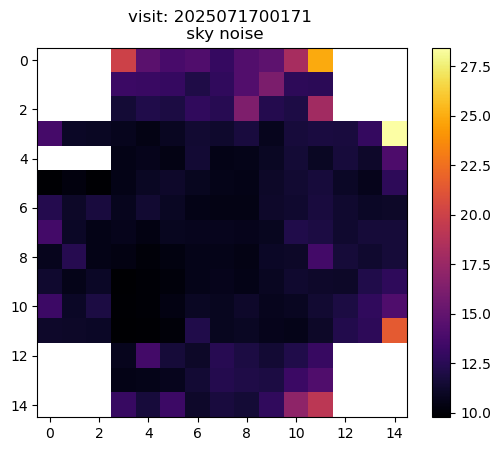

In [9]:
plt.imshow(det_skynoise, cmap='inferno')
plt.colorbar()
plt.title(f'visit: {visit} \n sky noise')

## Bin Ghosts per Detector

In [10]:
tot_ghosts = np.zeros_like(detids)
skynoise_frac = 1/3

impacting_ghosts = []

for sgs in gfs:
    for ghost in sgs:
        #do not include flux from star
        if ghost.name == 'Star':
            continue
    
        # bin the ghost into 15x15 grid (1 bin = 1 CCD)
        h = ghost.bin(15)
        
        nonzero_det_mask = (h!=0) & np.isfinite(detids)
        nonzero_detectors = detids[nonzero_det_mask]
        det_areas = np.zeros_like(h)

        # calculate the area that each ghost occupies on each detector
        detbins=25
        for det in nonzero_detectors:
            corners = tab[tab['detector']==det]
            g, _, _, _ = binned_statistic_2d(ghost.x, ghost.y, 
                                values = ghost.flux, 
                                bins=[int(detbins), int(detbins)], 
                                range=[[corners['min_x'].value, corners['max_x'].value], 
                                       [corners['min_y'].value, corners['max_y'].value]], 
                                statistic='sum');
            g = np.flipud(g.T)
    
            ##get bin size in mm
            x_binsize = (corners['max_x']-corners['min_x'])/detbins
            y_binsize = (corners['max_y']-corners['min_y'])/detbins
            
            area = np.count_nonzero(g)*x_binsize*y_binsize
    
            # convert area to pixel^2
            area_px = area * (rv.LSSTCamConstants.mm_to_pixel)**2
            #print(area_px)
            idx = np.where(detids==int(det))
            det_areas[idx] = area_px.value
            
        # divide ghost flux by area to get units of instrumental flux per pixel
        pred = h/det_areas
        pred[~np.isfinite(pred)] = 0
    
        # calculate the ghost to sky noise ratio
        ratio = pred/det_skynoise
    
        # calculate mask for ghosts that cross the ratio > 1/3 threshold
        mask = (ratio >= skynoise_frac)
    
        # if more than 1 detectors cross the 1/3 threshold, the ghost is marked as "impacting"
        if np.sum(mask) >= 1:
            impacting_ghosts.append(ghost)
        # fig.suptitle(f'{ghost.name}')
        # fig, ax = plt.subplots(ncols=2)
        # im = ax[0].imshow(ratio)
        # plt.colorbar(im)
        # ax[1].imshow(mask)
        
        tot_ghosts += pred

/home/p/pai/sciunit_lsb/notebooks/ipykernel_31234/2537160718.py:44: RuntimeWarning: divide by zero encountered in divide
  pred = h/det_areas
/home/p/pai/sciunit_lsb/notebooks/ipykernel_31234/2537160718.py:44: RuntimeWarning: invalid value encountered in divide
  pred = h/det_areas


/home/p/pai/sciunit_lsb/notebooks/ipykernel_31234/651774862.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(tot_ghosts), cmap='inferno')


Text(0.5, 1.0, 'visit: 2025071700171 \n binned ghosts')

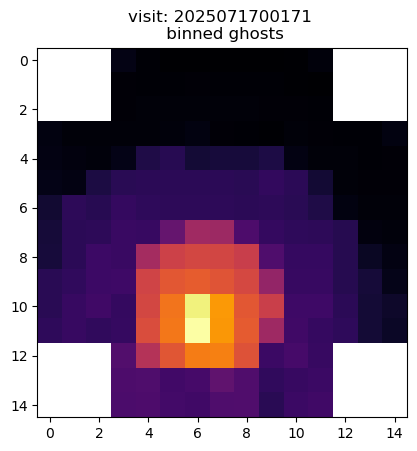

In [11]:
plt.imshow(np.log10(tot_ghosts), cmap='inferno')
plt.title(f'visit: {visit} \n binned ghosts')

## Find Impacting Ghosts

/home/p/pai/sciunit_lsb/notebooks/ipykernel_31234/3013105289.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(binned_impacting_ghosts), cmap='inferno', extent=[rv.LSSTCamConstants.fp_min_x.value,


Text(0.5, 1.0, 'impacted area: 354138410.19 px \n fraction: 8.84%')

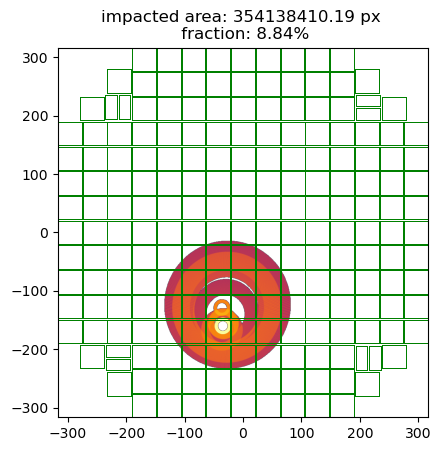

In [12]:
impacting_ghosts = rv.StarGhostSet(ghosts=impacting_ghosts)
binned_impacting_ghosts = impacting_ghosts.bin(1000)

x_binsize = rv.LSSTCamConstants.fp_width/1000
y_binsize = rv.LSSTCamConstants.fp_height/1000

# impacted area 
impacted_area = np.count_nonzero(binned_impacting_ghosts) * x_binsize * y_binsize * (rv.LSSTCamConstants.mm_to_pixel)**2
total_area = rv.LSSTCamConstants.fp_width * rv.LSSTCamConstants.fp_height * (rv.LSSTCamConstants.mm_to_pixel)**2

plt.imshow(np.log10(binned_impacting_ghosts), cmap='inferno', extent=[rv.LSSTCamConstants.fp_min_x.value, 
                                                      rv.LSSTCamConstants.fp_max_x.value, 
                                                      rv.LSSTCamConstants.fp_min_y.value, 
                                                      rv.LSSTCamConstants.fp_max_y.value])

for j in range(205):
        min_x = tab['min_x']
        min_y = tab['min_y']
    
        max_x = tab['max_x']
        max_y = tab['max_y']
        plt.vlines(min_x, min_y, max_y, color='g', lw=0.5)
        plt.hlines(min_y, min_x, max_x, color='g', lw=0.5)
        plt.vlines(max_x, min_y, max_y, color='g', lw=0.5)
        plt.hlines(max_y, min_x, max_x, color='g', lw=0.5)
    
plt.title(f'impacted area: {impacted_area.value:.2f} px \n fraction: {impacted_area.value/total_area.value*100:.2f}%')

## Scratch